In [1]:
!pip install tensorflow==2.0

     |████████████████████████████████| 86.3MB 52kB/s 
     |████████████████████████████████| 3.8MB 55.4MB/s 
     |████████████████████████████████| 450kB 63.6MB/s 
     |████████████████████████████████| 81kB 13.2MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

Reproduced with code from this excellent [blog](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a)

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
tf.__version__

'2.0.0'

### Load data from .csv file

* `train-images-boxable.csv` file contains the image name and image url
* `train-annotations-bbox.csv` file contains the bounding box info with the image id (name) and the image label name
* `class-descriptions-boxable.csv` file contains the image label name corresponding to its class name

Download link:

https://storage.googleapis.com/openimages/web/download.html

https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/

In [11]:
!python -m wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv


Saved under train-annotations-bbox.csv


In [12]:
!python -m wget https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv


Saved under train-images-boxable-with-rotation.csv


The original code used "***train-images-boxable.csv***" but I couldn't find it. So, I am using "***train-images-boxable-with-rotations.csv"***

In [13]:
!python -m wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv


Saved under class-descriptions-boxable.csv


In [3]:
images_boxable_fname = 'train-images-boxable-with-rotation.csv'
annotations_bbox_fname = 'train-annotations-bbox.csv'
class_descriptions_fname = 'class-descriptions-boxable.csv'

In [4]:
images_boxable = pd.read_csv(images_boxable_fname)
images_boxable.head()

ImageID Subset                                        OriginalURL  \
0  4fa8054781a4c382  train  https://farm3.staticflickr.com/5310/5898076654...   
1  b37f763ae67d0888  train  https://c1.staticflickr.com/1/67/197493648_628...   
2  7e8584b0f487cb9e  train  https://c7.staticflickr.com/8/7056/7143870979_...   
3  86638230febe21c4  train  https://farm5.staticflickr.com/5128/5301868579...   
4  249086e72671397d  train  https://c6.staticflickr.com/4/3930/15342460029...   

                                  OriginalLandingURL  \
0  https://www.flickr.com/photos/michael-beat/589...   
1  https://www.flickr.com/photos/drstarbuck/19749...   
2  https://www.flickr.com/photos/circasassy/71438...   
3  https://www.flickr.com/photos/ajcreencia/53018...   
4  https://www.flickr.com/photos/codnewsroom/1534...   

                                        License  \
0  https://creativecommons.org/licenses/by/2.0/   
1  https://creativecommons.org/licenses/by/2.0/   
2  https://creativecommons.org/licenses/by/2.0/   
3  https://creativecommons.org/licenses/by/2.0/   
4  https://creativecommons.org/licenses/by/2.0/   

                              AuthorProfileURL        Author  \
0  https://www.flickr.com/people/michael-beat/  Michael Beat   
1    https://www.flickr.com/people/drstarbuck/         Karen   
2    https://www.flickr.com/people/circasassy/    CircaSassy   
3    https://www.flickr.com/people/ajcreencia/          Alex   
4   https://www.flickr.com/people/codnewsroom/  COD Newsroom   

                                               Title  OriginalSize  \
0                                   ...die FNF-Kerze       4405052   
1                               Three boys on a hill        494555   
2  A Christmas carol and The cricket on the heart...       2371584   
3                                    Abbey and Kenny        949267   
4  Suburban Law Enforcement Academy 20th Annivers...       6541758   

                OriginalMD5  \
0  KFukvivpCM5QXl5SqKe41g==   
1  9IzEn38GRNsVpATuv7gzEA==   
2  3hQwu0iSzY1VIoXiwp0/Mg==   
3  onB+rCZnGQg5PRX7xOs18Q==   
4  MjpaAVbMAWbCusSaxI1D7w==   

                                    Thumbnail300KURL  Rotation  
0  https://c1.staticflickr.com/6/5310/5898076654_...       0.0  
1  https://c3.staticflickr.com/1/67/197493648_628...       0.0  
2  https://c7.staticflickr.com/8/7056/7143870979_...       0.0  
3  https://c4.staticflickr.com/6/5128/5301868579_...       NaN  
4  https://c1.staticflickr.com/4/3930/15342460029...       0.0

In [5]:
annotations_bbox = pd.read_csv(annotations_bbox_fname)
annotations_bbox.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.148438  0.587500           0            1          0            0   
1  0.714063  0.948438           0            1          0            0   
2  0.198437  0.590625           1            0          0            0   
3  0.651563  0.925000           1            0          0            0   
4  0.235938  0.385938           1            0          0            0   

   IsInside  
0         0  
1         0  
2         0  
3         0  
4         0

1. **XMin, XMax, YMin, YMax**: coordinates of the box, in normalized image coordinates.
2. **IsOccluded**: Indicates that the object is occluded by another object in the image.
3. **IsTruncated**: Indicates that the object extends beyond the boundary of the image.
4. **IsGroupOf**: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
5. **IsDepiction**: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
6. **IsInside**: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).


In [7]:
class_descriptions = pd.read_csv(class_descriptions_fname, header=None)
class_descriptions.head()

0           1
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football

### Plot Bounding box

In [9]:
def plot_bbox(img_id):
  img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

Finding images with lesser number of objects so as easy to visualize

In [10]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

Image: (2448, 3264, 3)
Coordinates: (0, 0), (3261, 673)


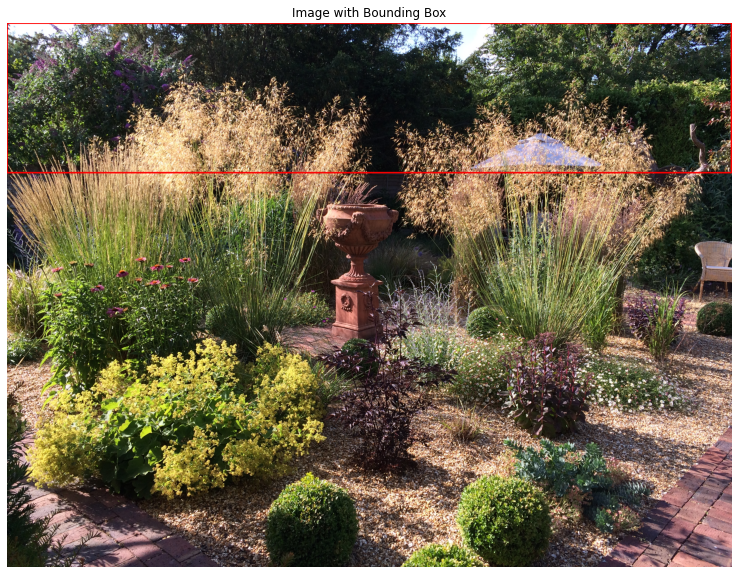

Image: (1600, 2400, 3)
Coordinates: (187, 1430), (1900, 1584)


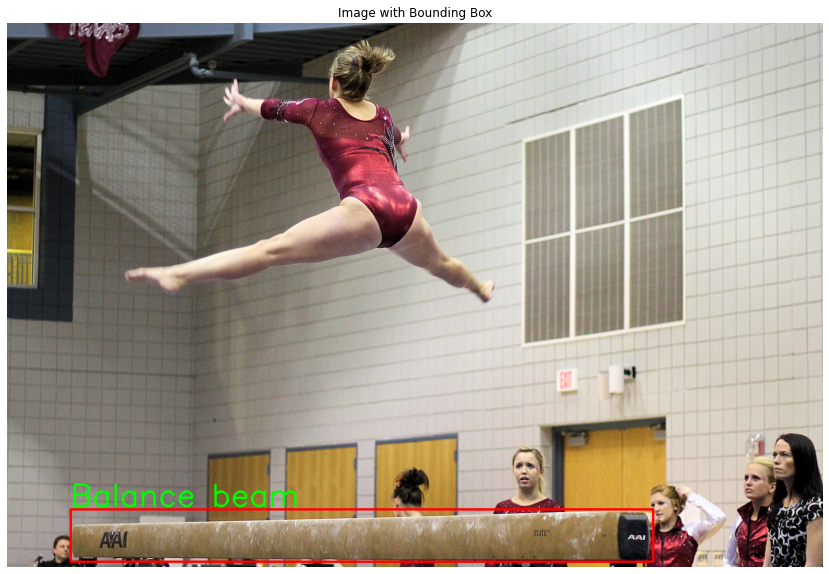

Image: (650, 488, 3)
Coordinates: (109, 106), (337, 600)


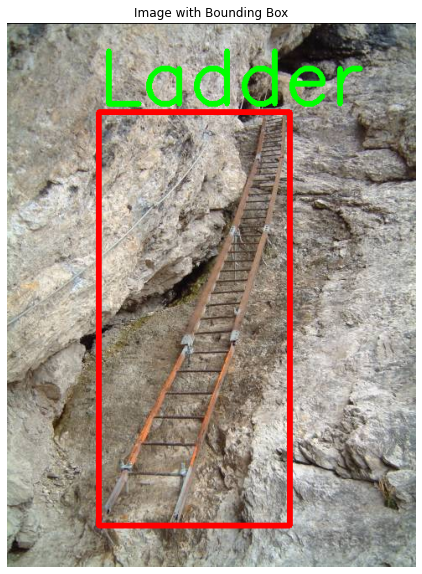

HTTPError: HTTP Error 404: Not Found

In [11]:
for img_id in random.sample(list(least_objects_img_ids), 5):
  plot_bbox(img_id)

### Get subset of the whole dataset

For here, I just want to detect three classes, which include person, mobile phone and car. We just extract 1000 images for each class from the whole dataset.

In [12]:
class_descriptions.loc[class_descriptions[1].isin(['Car', 'Vehicle registration plate'])]

0                           1
82   /m/01jfm_  Vehicle registration plate
570    /m/0k4j                         Car

In [13]:
# Find the label_name for 'Person', 'Mobile Phone' and 'Car' classes
car_pd = class_descriptions[class_descriptions[1]=='Car']
rplate_pd = class_descriptions[class_descriptions[1]=='Vehicle registration plate']


label_name_car = car_pd[0].values[0]
label_name_rplate = rplate_pd[0].values[0]


**Be careful that there might be several object in one image. For example, there are three person and two mobile phone in one image**

In [14]:
car_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_car]
rplate_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_rplate]

In [15]:
print('There are %d cars in the dataset' %(len(car_bbox)))
print('There are %d rplate in the dataset' %(len(rplate_bbox)))
car_img_id = car_bbox['ImageID']
rplate_img_id = rplate_bbox['ImageID']

There are 248075 cars in the dataset
There are 7852 rplate in the dataset


In [16]:
car_img_id = np.unique(car_img_id)
rplate_img_id = np.unique(rplate_img_id)

print('There are %d images which contain cars' % (len(car_img_id)))
print('There are %d images which contain car platess' % (len(rplate_img_id)))

There are 89465 images which contain cars
There are 5368 images which contain car platess


We just randomly pick 1000 images in here.

In [17]:
# here I've chosen only 10 images for speed, change it to your liking
n = 1000
subcar_img_id = random.sample(list(car_img_id), n)
subrplate_img_id = random.sample(list(rplate_img_id),n)

In [18]:

subcar_pd = images_boxable.loc[images_boxable['ImageID'].isin(subcar_img_id)]
subrplate_pd = images_boxable.loc[images_boxable['ImageID'].isin(subrplate_img_id)]

In [19]:
subcar_pd.shape

(1000, 12)

In [20]:
subcar_pd.head()

ImageID Subset  \
1487  1eebe557dcf69b41  train   
3482  ee434590d93e3c79  train   
4072  c2ad7b6224d51fed  train   
5026  8ae5f640f6bee4f6  train   
6450  0c8c7245cded4566  train   

                                            OriginalURL  \
1487  https://farm2.staticflickr.com/7627/1676957005...   
3482  https://c2.staticflickr.com/9/8282/7762771294_...   
4072  https://c6.staticflickr.com/4/3119/3360017755_...   
5026  https://farm7.staticflickr.com/2347/2327357436...   
6450  https://farm7.staticflickr.com/3863/1511464624...   

                                     OriginalLandingURL  \
1487  https://www.flickr.com/photos/satguru/16769570055   
3482  https://www.flickr.com/photos/50415738@N04/776...   
4072  https://www.flickr.com/photos/auntylaurie/3360...   
5026  https://www.flickr.com/photos/willvision/23273...   
6450  https://www.flickr.com/photos/trondheim_byarki...   

                                           License  \
1487  https://creativecommons.org/licenses/by/2.0/   
3482  https://creativecommons.org/licenses/by/2.0/   
4072  https://creativecommons.org/licenses/by/2.0/   
5026  https://creativecommons.org/licenses/by/2.0/   
6450  https://creativecommons.org/licenses/by/2.0/   

                                      AuthorProfileURL  \
1487            https://www.flickr.com/people/satguru/   
3482       https://www.flickr.com/people/50415738@N04/   
4072        https://www.flickr.com/people/auntylaurie/   
5026         https://www.flickr.com/people/willvision/   
6450  https://www.flickr.com/people/trondheim_byarkiv/   

                               Author  \
1487                     David Howard   
3482                          sv1ambo   
4072                   Laurie Avocado   
5026                       WillVision   
6450  Municipal Archives of Trondheim   

                                        Title  OriginalSize  \
1487                                  lighten       2056207   
3482           1976 Holden TX Gemini SL coupe       5310776   
4072             North Main and Elmyra Street        117480   
5026  Zenki's Nissan Silvia PS13 RC Drift Car        449329   
6450                    Jomfrugata (ca. 1976)       7164509   

                   OriginalMD5  \
1487  7mwYWp56t51LoUK+7SLbZg==   
3482  M+gGGH4+YZhWbAoXEr5Ejw==   
4072  +WVlDk8KN/rk4NSzUgpnFw==   
5026  r36OGSLeGY9L9axDvTlG3A==   
6450  CBtJLnCjxx+pW2jnanz0Qw==   

                                       Thumbnail300KURL  Rotation  
1487  https://c7.staticflickr.com/8/7627/16769570055...       0.0  
3482  https://c1.staticflickr.com/9/8282/7762771294_...       0.0  
4072  https://c8.staticflickr.com/4/3119/3360017755_...       0.0  
5026  https://c7.staticflickr.com/3/2347/2327357436_...       0.0  
6450  https://c5.staticflickr.com/4/3863/15114646246...       0.0

In [21]:
subcar_dict = subcar_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subrplate_dict = subrplate_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()

In [22]:
# subperson_img_url = subperson_pd['OriginalURL'].tolist()
# subphone_img_url = subphone_pd['OriginalURL'].tolist()
# subcar_img_url = subcar_pd['OriginalURL'].tolist()

In [23]:
mappings = [subcar_dict, subrplate_dict]

In [24]:
len(mappings)

2

In [25]:
len(mappings[0])

1000

In [26]:
classes = ['Car','Vehicle registration plate']

### Download images

We need to save the images with filename as `image id` with jpg extension

In [27]:
# download images
for idx, obj_type in enumerate(classes):
  n_issues = 0
  # create the directory
  if not os.path.exists(obj_type):
    os.mkdir(obj_type)
  for img_id, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(obj_type, img_id+".jpg")
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

Images Issues: 69


D:\Anaconda\envs\tensorflow2\lib\site-packages\PIL\TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6396109830 bytes but only got 0. Skipping tag 24953
  " Skipping tag %s" % (size, len(data), tag)
D:\Anaconda\envs\tensorflow2\lib\site-packages\PIL\TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 3. 
  warnings.warn(str(msg))


Images Issues: 58


In [38]:
!python -m ls Person | wc -l

'wc'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [83]:
!ls Mobile\ phone | wc -l

7


In [84]:
!ls Car | wc -l

9


### Dataset format for Faster-RCNN code

(fname_path, xmin, xmax, ymin, ymax, class_name)

train: 0.8
validation: 0.2

In [28]:
# save images to train and test directory
train_path = 'train'
test_path = 'test'

In [29]:
!mkdir train test

하위 디렉터리 또는 파일 train이(가) 이미 있습니다.
다음 내용 진행 중 오류 발생: train.
하위 디렉터리 또는 파일 test이(가) 이미 있습니다.
다음 내용 진행 중 오류 발생: test.


In [30]:
random.seed(1)

In [31]:
for i in range(len(classes)):
    all_imgs = os.listdir(classes[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(n*0.8)

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]
    
    # copy each classes' images to train directory
    for j in range(len(train_imgs)):
        original_path = os.path.join(classes[i], train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    
    # copy each classes' images to test directory
    for j in range(len(test_imgs)):
        original_path = os.path.join(classes[i], test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)

In [94]:
!ls train | wc -l

23


In [95]:
!ls test | wc -l

3


The expected number of training images and validation images should be 24 and 6 respectively.

However, there might be some overlap images which appear in two or three classes simultaneously. For instance, an image might be a person walking on the street and there are several cars in the street

In [32]:
label_names = [label_name_car, label_name_rplate]

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [33]:
train_df.head()

FileName      XMin      XMax      YMin      YMax  \
0  0005ea10e0e14db1.jpg  0.847005  0.908854  0.383789  0.423828   
1  0005ea10e0e14db1.jpg  0.000000  0.755208  0.000000  0.672852   
2  0005ea10e0e14db1.jpg  0.792318  0.999349  0.149414  0.492188   
3  0006dc0977056410.jpg  0.388750  0.494375  0.714286  0.739535   
4  000812dcf304a8e7.jpg  0.396875  0.481250  0.792587  0.833215   

                    ClassName  
0  Vehicle registration plate  
1                         Car  
2                         Car  
3  Vehicle registration plate  
4  Vehicle registration plate

In [34]:
train_df.shape

(5639, 6)

Let's test if they work fine by plotting the bounding box for the above 5 images

In [35]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique()

Image: (1024, 1536, 3)
Coordinates: (361, 46), (471, 186)
Coordinates: (1208, 197), (1234, 284)
Coordinates: (1300, 392), (1395, 433)
Coordinates: (140, 426), (469, 739)
Coordinates: (365, 120), (432, 165)
Coordinates: (990, 410), (1101, 574)
Coordinates: (1228, 426), (1297, 467)
Coordinates: (0, 0), (1159, 689)
Coordinates: (1217, 152), (1535, 504)
Coordinates: (0, 0), (1171, 698)


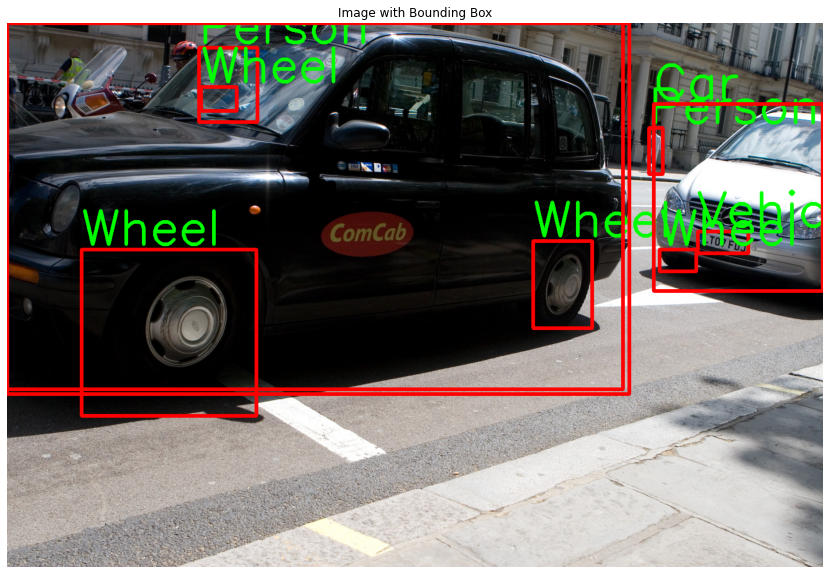

Image: (2010, 2136, 3)
Coordinates: (607, 0), (703, 193)
Coordinates: (903, 770), (1166, 948)
Coordinates: (830, 1435), (1055, 1486)
Coordinates: (587, 357), (2017, 1661)


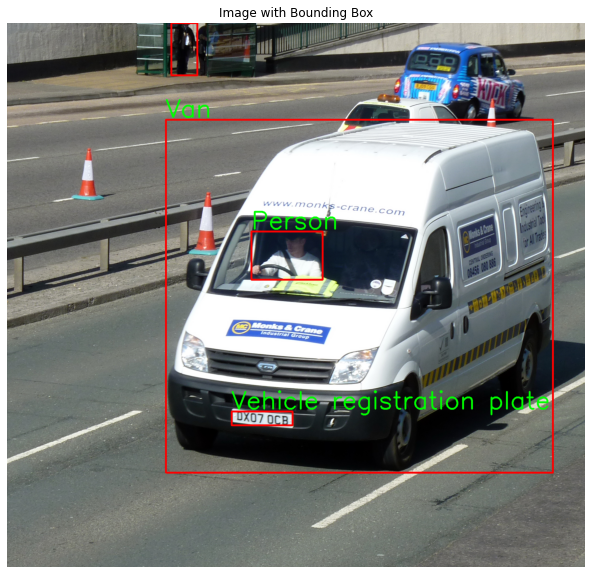

Image: (1579, 1800, 3)
Coordinates: (106, 47), (1527, 1513)
Coordinates: (714, 1251), (866, 1315)
Coordinates: (226, 1189), (397, 1528)
Coordinates: (385, 1385), (480, 1447)
Coordinates: (505, 1393), (624, 1452)
Coordinates: (1000, 561), (1179, 599)
Coordinates: (1135, 1362), (1219, 1436)
Coordinates: (1221, 1140), (1389, 1540)
Coordinates: (1368, 1052), (1454, 1455)
Coordinates: (222, 1137), (393, 1510)
Coordinates: (407, 1308), (493, 1422)
Coordinates: (510, 1252), (630, 1466)
Coordinates: (1154, 1271), (1229, 1476)
Coordinates: (1225, 1106), (1392, 1520)


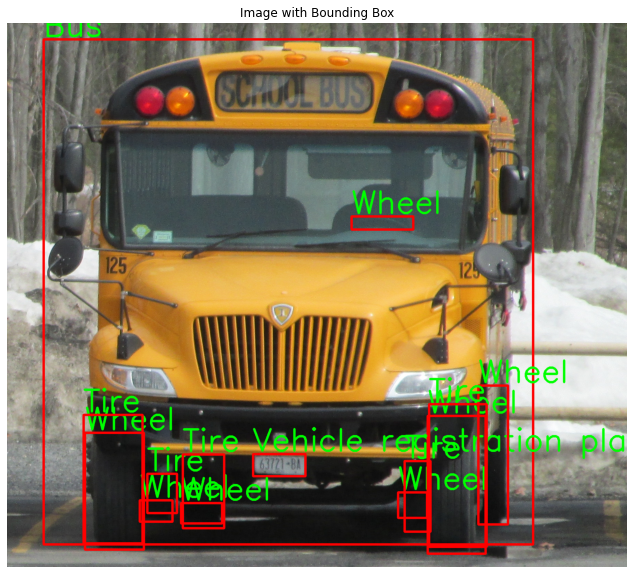

In [36]:
for img_id in train_img_ids:
  plot_bbox(img_id)

**This looks fine to me!!**

In [40]:
val_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(val_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                val_df = val_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [41]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

### Write train.csv to annotation.txt

In [42]:
train_df = pd.read_csv('train.csv')

# for training
with open("annotation.txt", "w+") as f:
  for idx, row in train_df.iterrows():
      img = cv2.imread('train/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      file_path = './train'
      fileName = os.path.join(file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [43]:
test_df = pd.read_csv('test.csv')

# for test
with open("test_annotation.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      img = cv2.imread('test/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      file_path = './test'
      fileName = os.path.join(file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')